# Итоговый проект модуля 2 "Анализ лояльности пользователей Яндекс Афиши"

### Автор: Малахов Дмитрий
### Дата: 2026

# 0.1 Цели и задачи проекта
Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

# 0.2 Описание данных:
user_id — уникальный идентификатор пользователя, совершившего заказ;

device_type_canonical — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);

order_id — уникальный идентификатор заказа;

order_dt — дата создания заказа (используйте данные created_dt_msk );

order_ts — дата и время создания заказа (используйте данные created_ts_msk );

currency_code — валюта оплаты;

revenue — выручка от заказа;

tickets_count — количество купленных билетов;

days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;

event_id — уникальный идентификатор мероприятия;

service_name — название билетного оператора;

event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);

region_name — название региона, в котором прошло мероприятие;

city_name — название города, в котором прошло мероприятие.

# 0.3 Содержание проекта
Команда маркетинга хочет лучше понимать поведение пользователей. Это позволит:
- быстро выявлять перспективных клиентов и предлагать им персонализированные условия;

- точно настраивать рекламу на аудитории с высокой вероятностью возврата;

- оптимизировать маркетинговые бюджеты;

- повысить общий уровень удержания клиентов.

# 1 Загрузка данных и знакомство с ними
* Загружены необходимые библиотеки Python;
* Загружены данные о заведениях общественного питания Москвы

## 1.1 Подключение к базе данных с помощью Python

In [1]:
# !pip install sqlalchemy

In [2]:
# !pip install psycopg2

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [4]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string)

## 1.2 Извлечение результатов SQL-запроса

In [7]:
query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

-- Напишите ваш запрос ниже
SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk AS order_dt,
    created_ts_msk AS order_ts,
    currency_code,
    revenue,
    tickets_count,
    -- Расчёт времени между заказами каждого пользователя:
    created_dt_msk::date - LAG(created_dt_msk::date ) 
        OVER(PARTITION BY user_id ORDER BY created_dt_msk)
        AS days_since_prev,
    e.event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE
    -- Фильтрация по типам устройств
    device_type_canonical IN ('mobile','desktop') AND
    event_type_main != 'фильм'
ORDER BY user_id
'''

In [8]:
df = pd.read_sql_query(query, con=engine)

In [9]:
df.head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье


In [10]:
df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

## Промежуточные выводы:
* 290611 строк и 15 столбцов;
* Проблем с качеством данных не вижу, за исключением одного столбца - days_since_prev. Так как это количество дней, следует преобразовать в тип int;
* при этом только в этом столбце есть пропуски (примерно 10%), что по условию задачи является индикатором одного заказа у пользователя.


# 2 Предобработка данных

## Задача 2.1. Приведение выручки к единой валюте — российскому рублю


In [11]:
df_conversion = pd.read_csv('C:/datasets/final_tickets_tenge_df.csv')

In [12]:
df_conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [13]:
df_conversion.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Изменение типа данных столбца data:

In [14]:
df_conversion['data'] = pd.to_datetime(df_conversion['data'])

In [15]:
df_conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


Теперь объединение:

In [16]:
df = df.merge(df_conversion, how='left', left_on='order_dt', right_on='data')
df.head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск,2024-10-23,100,20.0531,kzt
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-15,100,18.7730,kzt
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск,2024-09-29,100,19.3741,kzt
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск,2024-10-15,100,19.7185,kzt
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,2024-06-20,100,18.0419,kzt


Новый столбец в рублях:

In [17]:
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)

In [18]:
df.head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt,1390.41
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск,2024-10-23,100,20.0531,kzt,902.74
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-15,100,18.7730,kzt,917.83
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск,2024-09-29,100,19.3741,kzt,47.78
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск,2024-10-15,100,19.7185,kzt,74.84
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,2024-06-20,100,18.0419,kzt,1421.91


## Задача 2.2. Распределение численных данных и наличие в них выбросов.

Как писал выше, привожу столбец days_since_prev к типу int

In [19]:
df['days_since_prev'] = df['days_since_prev'].astype('Int64')

Также столбец order_id можно привести к типу int:

In [20]:
df['order_id'] = df['order_id'].astype('Int64')

Распределение значений в числовых столбцах и наличие выбросов

In [21]:
df['revenue_rub'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
1%            0.000000
25%         113.970000
50%         351.140000
75%         802.050000
90%        1294.770000
95%        1630.650000
99%        2628.421739
max       81174.540000
Name: revenue_rub, dtype: float64

Видно отрицательные значения, определяю количество:

In [22]:
negative_count = (df['revenue_rub'] < 0).sum()
print(negative_count)

381


Нужно удалить из-за малого количества (381):


In [23]:
df = df[df['revenue_rub'] > 0]

Проверка:

In [24]:
df['revenue_rub'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    284704.000000
mean        567.102254
std         880.828883
min           0.020000
1%            8.160000
25%         124.730000
50%         364.280000
75%         811.610000
90%        1303.260000
95%        1645.200000
99%        2628.421739
max       81174.540000
Name: revenue_rub, dtype: float64

Ящик с усами для revenue_rub:

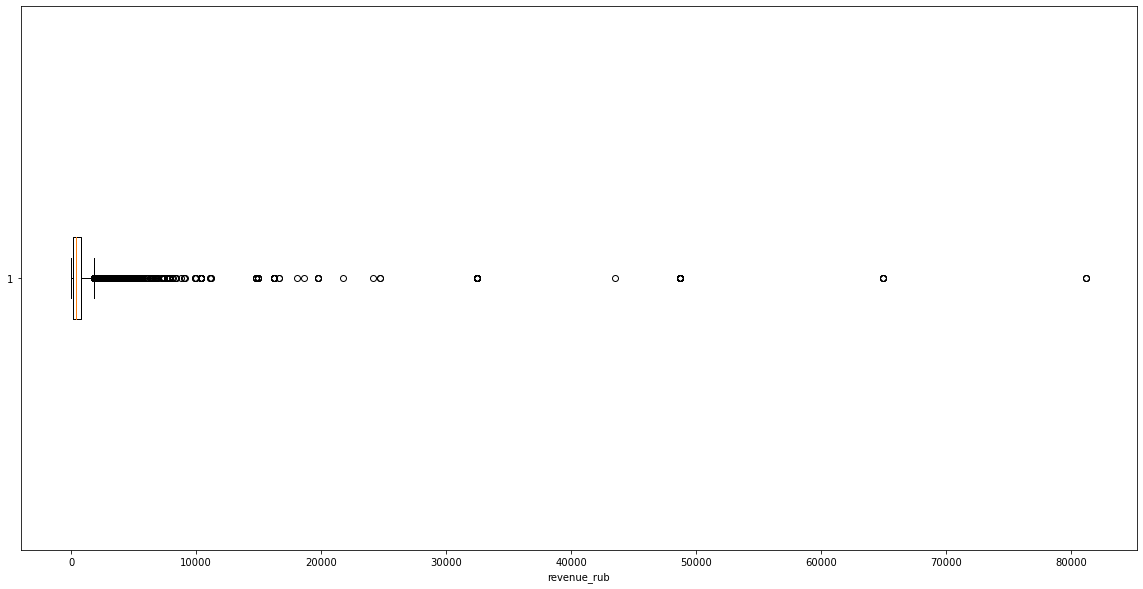

In [25]:
plt.figure(figsize=(20, 10))
plt.boxplot(df['revenue_rub'], vert=False)
plt.xlabel('revenue_rub')
plt.show()    

Выбросы в поле revenue_rub фильтруются по 99 перцентилю:

In [26]:
revenue_rub_99perc = df['revenue_rub'].quantile(0.999)
df = df[(df['revenue_rub'] < revenue_rub_99perc)]
df['revenue_rub'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99,0.999])

count    284410.000000
mean        552.803621
std         570.892342
min           0.020000
1%            8.160000
25%         124.552500
50%         363.910000
75%         810.410000
90%        1297.220000
95%        1630.650000
99%        2594.440000
99.9%      4038.630000
max        5113.160000
Name: revenue_rub, dtype: float64

Для tickets_count ящик с усами и гистограмма:

In [27]:
df['tickets_count'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    284410.000000
mean          2.757213
std           1.164386
min           1.000000
1%            1.000000
25%           2.000000
50%           3.000000
75%           4.000000
90%           4.000000
95%           5.000000
99%           6.000000
max          47.000000
Name: tickets_count, dtype: float64

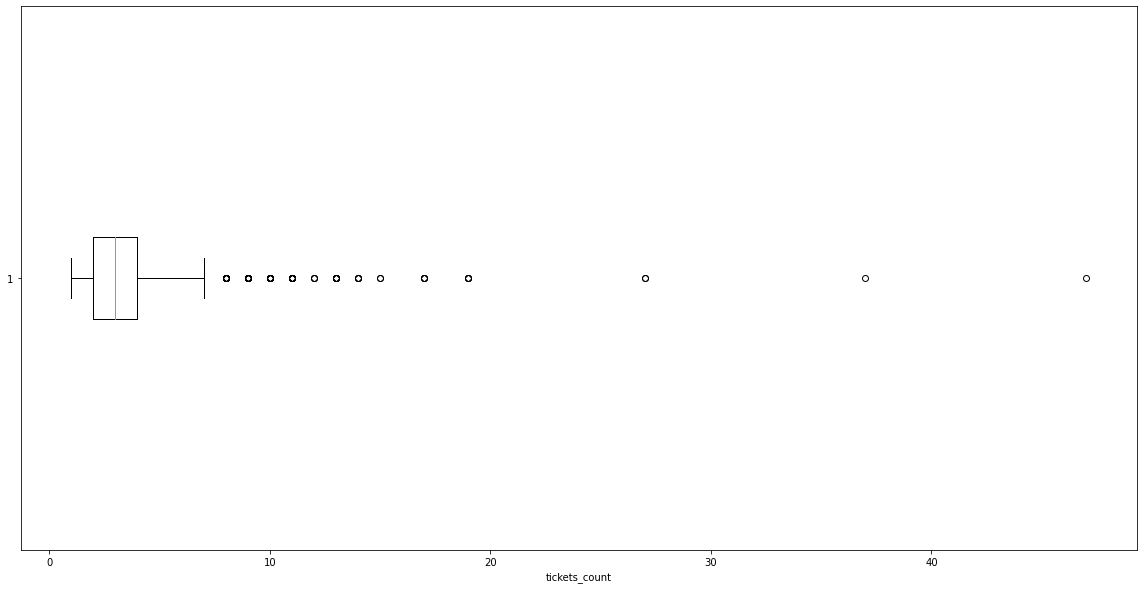

In [28]:
plt.figure(figsize=(20, 10))
plt.boxplot(df['tickets_count'], vert=False)
plt.xlabel('tickets_count')
plt.show()

## Промежуточные выводы:
* Для быстрой работы вследствие меньшей нагрузки на систему были изменены типы у некоторых столбцов;
* Удалены строки, имеющие отрицательные значения цен;
* Проверено распределение численных данных и наличие в них выбросов в столбцах tickets_count и revenue_rub.

# 3. Создание профиля пользователя
В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

## Задача 3.1. Построение профиля пользователя

Сортировка:

In [29]:
df = df.sort_values(['user_id', 'order_dt'])

Создание профиля:

In [30]:
profile = df.groupby('user_id').agg(
    first_order_date = ('order_dt', 'first'),
    last_order_date = ('order_dt', 'last'),
    type_device = ('device_type_canonical', 'first'),
    region = ('region_name', 'first'),
    ticket_partner = ('service_name', 'first'),
    first_event_type = ('event_type_main', 'first'),
    total_orders = ('order_id', 'count'),
    avg_revenue_rub = ('revenue_rub', 'mean'),
    avg_tickets = ('tickets_count', 'mean')
).reset_index()

Показатель среднего времени между заказами вычислим следующим образом: находим разницу для пользователя, вычисляем среднее, добавляем в профиль

In [31]:
df['days_between_orders'] = df.groupby('user_id')['order_dt'].diff().dt.days
average_days = df.groupby('user_id')['days_between_orders'].mean()
profile = profile.merge(average_days, on='user_id', how='left')   

Бинарные признаки:

In [32]:
profile['is_two'] = (profile['total_orders'] >= 2).astype('uint8')
profile['is_five'] = (profile['total_orders'] >= 5).astype('uint8')
profile.head(10)

,user_id,first_order_date,last_order_date,type_device,region,ticket_partner,first_event_type,total_orders,avg_revenue_rub,avg_tickets,days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000000,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.000000,1,0
7,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,NaN,0,0
8,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.500000,1,0
9,0020c5654c92ec1,2024-07-02,2024-07-02,mobile,Каменевский регион,Билеты без проблем,концерты,2,193.420000,2.000000,0.000000,1,0


## Задача 3.2. Оценка репрезентативности данных и наличия в них аномалий

Расчет следующих показателей:
1. Общее число пользователей в выборке;
2. Средняя выручка с одного заказа;
3. Доля пользователей, совершивших 2 и более заказа;
4. Доля пользователей, совершивших 5 и более заказов.

In [33]:
total_users = len(profile)
avg_revenue_per_order = profile['avg_revenue_rub'].mean()
is_two_or_more = (profile['is_two'] == 1).mean()
is_five_or_more = (profile['is_five'] == 1).mean()

Вывод:

In [34]:
print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с 2 и более заказами: {is_two_or_more:.2%}")
print(f"Доля пользователей с 5 и более заказами: {is_five_or_more:.2%}")

Общее число пользователей: 21771
Средняя выручка с одного заказа: 571.58 руб.
Доля пользователей с 2 и более заказами: 61.79%
Доля пользователей с 5 и более заказами: 29.04%


Статистические показатели:

1. По общему числу заказов;

In [35]:
profile['total_orders'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    21771.000000
mean        13.063709
std        120.503443
min          1.000000
1%           1.000000
25%          1.000000
50%          2.000000
75%          5.000000
90%         15.000000
95%         31.000000
99%        151.300000
max      10056.000000
Name: total_orders, dtype: float64

2. По среднему числу билетов в заказе;

In [36]:
profile['avg_tickets'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    21771.000000
mean         2.757613
std          0.919805
min          1.000000
1%           1.000000
25%          2.000000
50%          2.769231
75%          3.135749
90%          4.000000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

3. По среднему количеству дней между покупками.

In [37]:
profile['days_between_orders'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    13452.000000
mean        15.852943
std         22.328248
min          0.000000
1%           0.000000
25%          1.000000
50%          8.000000
75%         20.500000
90%         41.483333
95%         61.000000
99%        113.490000
max        148.000000
Name: days_between_orders, dtype: float64

Гистограммы для всех показателей:

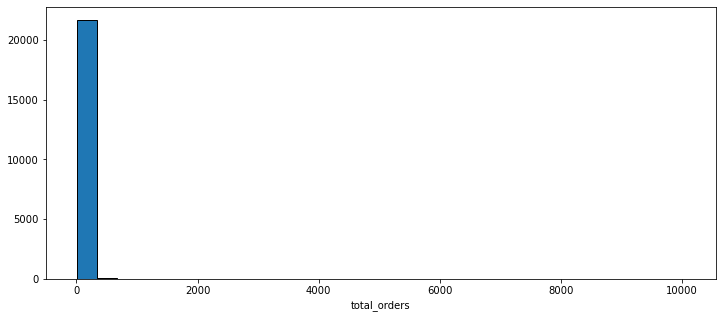

In [38]:
plt.figure(figsize=(12, 5))
plt.hist(profile['total_orders'], bins=30, edgecolor='black')
plt.xlabel('total_orders')
plt.show()

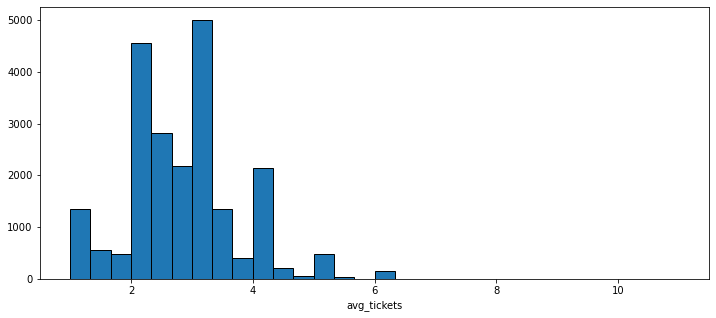

In [39]:
plt.figure(figsize=(12, 5))
plt.hist(profile['avg_tickets'], bins=30, edgecolor='black')
plt.xlabel('avg_tickets')
plt.show()

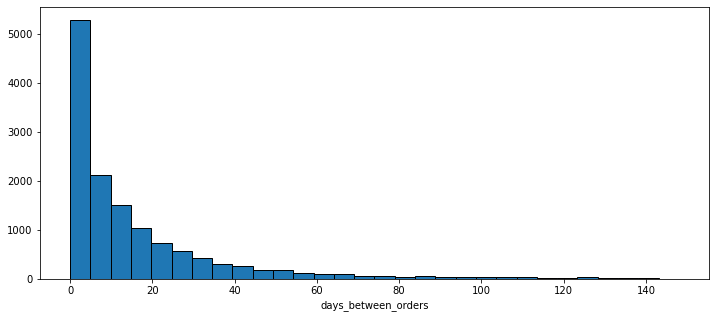

In [40]:
plt.figure(figsize=(12, 5))
plt.hist(profile['days_between_orders'], bins=30, edgecolor='black')
plt.xlabel('days_between_orders')
plt.show()

 Как можно видеть, выбросы характерны только для total_orders - cтатистический показатель по общему количеству заказов, следовательно, отфильтруем эти показатели

In [41]:
total_orders_99perc = profile['total_orders'].quantile(0.99)
profile = profile[(profile['total_orders'] <= total_orders_99perc)]

## Промежуточные выводы:

* Для статистический показателей фильтрация понадобилась только при расчете общего количества заказов - все остальные данные в норме;
* Общие значения (значения расчетов 2-ух/5-ти и более заказов, средненй выручки и общее число пользователей) являются нормальными, объем данных можно считать достаточным


# Шаг 4. Исследовательский анализ данных

## 4.1 Исследование признаков первого заказа и их связи с возвращением на платформу

## Задача 4.1.1. Распределение пользователей по признакам

### 4.1.1.1 Группировка по типу первого мероприятия и вычисление доли:

In [42]:
first_event_type = profile.groupby('first_event_type')['user_id'].nunique().reset_index()

In [43]:
first_event_type = (
    profile
    .groupby('first_event_type')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'user_count'})
)

first_event_type['dolya'] = (first_event_type['user_count'] / first_event_type['user_count'].sum()) * 100

In [44]:
first_event_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,first_event_type,user_count,dolya
0,концерты,9666,44.847585
1,другое,5217,24.205447
2,театр,4287,19.890502
3,стендап,1119,5.191853
4,спорт,766,3.554030
5,выставки,402,1.865170
6,ёлки,96,0.445414


### 4.1.1.2 Группировка по типу устройства, с которого совершена первая покупка:

In [45]:
first_device_type = profile.groupby('type_device')['user_id'].nunique().reset_index()

In [46]:
first_device_type = (
    profile
    .groupby('type_device')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'user_count'})
)

first_device_type['dolya'] = (first_device_type['user_count'] / first_device_type['user_count'].sum()) * 100

In [47]:
first_device_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,type_device,user_count,dolya
0,mobile,17825,82.703104
1,desktop,3728,17.296896


### 4.1.1.3 Группировка по региону проведения мероприятия из первого заказа

In [48]:
first_region_type = profile.groupby('region')['user_id'].nunique().reset_index()

In [49]:
first_region_type = (
    profile
    .groupby('region')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'user_count'})
)

first_region_type['dolya'] = (first_region_type['user_count'] / first_region_type['user_count'].sum()) * 100

In [50]:
first_region_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,region,user_count,dolya
0,Каменевский регион,7013,32.538394
1,Североярская область,3782,17.547441
2,Широковская область,1246,5.781098
3,Озернинский край,676,3.136454
4,Малиновоярский округ,531,2.463694
5,Светополянский округ,468,2.171391
6,Шанырский регион,466,2.162112
7,Травяная область,458,2.124994
8,Речиновская область,440,2.041479
9,Яблоневская область,412,1.911567


### 4.1.1.4 Группировка по билетному оператору, продавшему билеты на первый заказ

In [51]:
first_service_type = profile.groupby('ticket_partner')['user_id'].nunique().reset_index()

In [52]:
first_service_type = (
    profile
    .groupby('ticket_partner')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'user_count'})
)

first_service_type['dolya'] = (first_service_type['user_count'] / first_service_type['user_count'].sum()) * 100

In [53]:
first_service_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,ticket_partner,user_count,dolya
0,Билеты без проблем,4963,23.026957
1,Мой билет,3027,14.044449
2,Лови билет!,2821,13.088665
3,Билеты в руки,2535,11.761704
4,Облачко,2194,10.179557
5,Весь в билетах,1307,6.064121
6,Лучшие билеты,1184,5.493435
7,Прачечная,579,2.686401
8,Край билетов,468,2.171391
9,Дом культуры,348,1.614624


## Промежуточные выводы:
* Для типа первого мероприятия можно сказать, что 45% посетителей впервые пришло на концерты, далее пришлось на тип "другое" 24% и третьим по счету по популярности являются театры - 20%;
* основная часть пользователей заказ осуществляет с мобильного устройства - 83%;
* Каменевский район и Североярская область активнее проводили первые мероприятия - 32,5 и 17,5%. Остальные районы - 5 и менее процентов;
* Выделяется один крупный билетный оператор - билеты без проблем, на чью долю приходится 23%. Далее в среднем по 12% на каждый составляет группа из 4 операторов. Остальные - 6 и менее процентов

## Задача 4.1.2. Анализ возвратов пользователей\


Для каждого сегмента была вычеслена доля пользователей, совершивших два и более заказа:

### 4.1.2.1 Для типа первого мероприятия:

In [54]:
two_or_more_event = profile.groupby('first_event_type')['is_two'].mean().reset_index()
two_or_more_event = two_or_more_event.rename(columns={'is_two': 'two_or_more'})
two_or_more_event['two_or_more'] = two_or_more_event['two_or_more'] * 100
first_event_type = first_event_type.merge(two_or_more_event, on='first_event_type', how='left')
first_event_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,first_event_type,user_count,dolya,two_or_more
0,концерты,9666,44.847585,62.042210
1,другое,5217,24.205447,59.421123
2,театр,4287,19.890502,63.610917
3,стендап,1119,5.191853,60.857909
4,спорт,766,3.554030,55.091384
5,выставки,402,1.865170,63.184080
6,ёлки,96,0.445414,55.208333


### 4.1.2.2 Для типа устройства, с которого совершена первая покупка

In [55]:
two_or_more_device = profile.groupby('type_device')['is_two'].mean().reset_index()
two_or_more_device = two_or_more_device.rename(columns={'is_two': 'two_or_more'})
two_or_more_device['two_or_more'] = two_or_more_device['two_or_more'] * 100
first_device_type = first_device_type.merge(two_or_more_device, on='type_device', how='left')
first_device_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,type_device,user_count,dolya,two_or_more
0,mobile,17825,82.703104,60.869565
1,desktop,3728,17.296896,63.948498


### 4.1.2.3 Для региона проведения мероприятия из первого заказа

In [56]:
two_or_more_region = profile.groupby('region')['is_two'].mean().reset_index()
two_or_more_region = two_or_more_region.rename(columns={'is_two': 'two_or_more'})
two_or_more_region['two_or_more'] = two_or_more_region['two_or_more'] * 100
first_region_type = first_region_type.merge(two_or_more_region, on='region', how='left')
first_region_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,region,user_count,dolya,two_or_more
0,Каменевский регион,7013,32.538394,61.999144
1,Североярская область,3782,17.547441,64.225278
2,Широковская область,1246,5.781098,64.847512
3,Озернинский край,676,3.136454,54.733728
4,Малиновоярский округ,531,2.463694,55.743879
5,Светополянский округ,468,2.171391,66.025641
6,Шанырский регион,466,2.162112,70.386266
7,Травяная область,458,2.124994,61.353712
8,Речиновская область,440,2.041479,63.863636
9,Яблоневская область,412,1.911567,59.223301


### 4.1.2.4 Для билетного оператора, продавшего билеты на первый заказ

In [57]:
two_or_more_bilet = profile.groupby('ticket_partner')['is_two'].mean().reset_index()
two_or_more_bilet = two_or_more_bilet.rename(columns={'is_two': 'two_or_more'})
two_or_more_bilet['two_or_more'] = two_or_more_bilet['two_or_more'] * 100
first_service_type = first_service_type.merge(two_or_more_bilet, on='ticket_partner', how='left')
first_service_type.sort_values('user_count', ascending=False).reset_index(drop=True).head(10)

,ticket_partner,user_count,dolya,two_or_more
0,Билеты без проблем,4963,23.026957,59.802539
1,Мой билет,3027,14.044449,61.116617
2,Лови билет!,2821,13.088665,61.432116
3,Билеты в руки,2535,11.761704,62.840237
4,Облачко,2194,10.179557,61.394713
5,Весь в билетах,1307,6.064121,63.198164
6,Лучшие билеты,1184,5.493435,61.570946
7,Прачечная,579,2.686401,62.003454
8,Край билетов,468,2.171391,65.598291
9,Дом культуры,348,1.614624,64.080460


Столбчатые диаграммы для каждых типов:

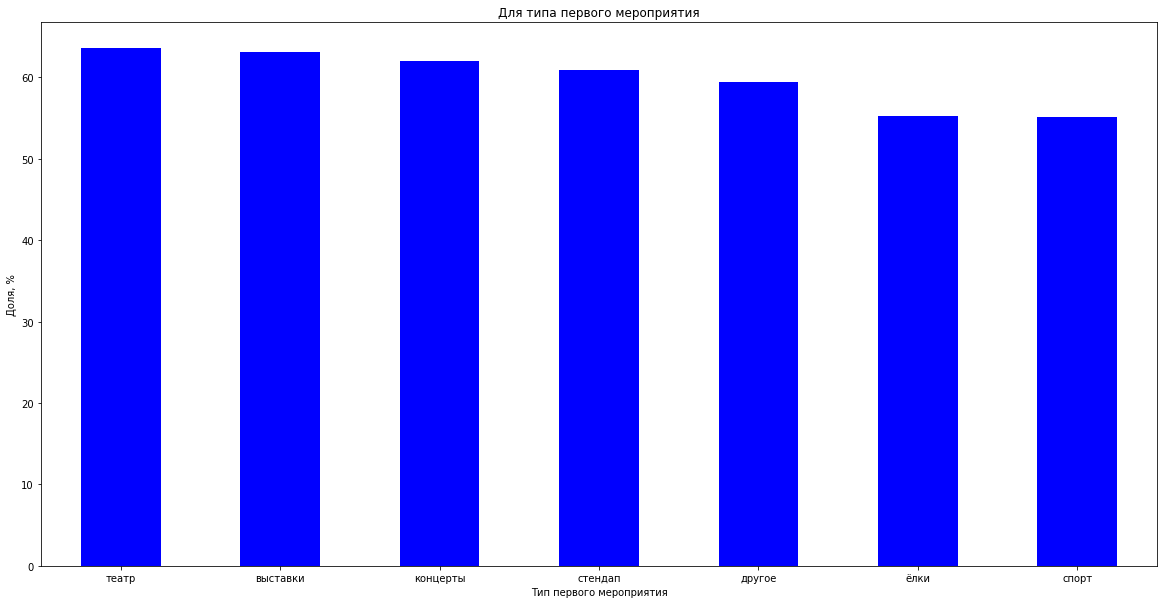

In [58]:
first_event_type = first_event_type.sort_values('two_or_more', ascending=False).reset_index(drop=True)
first_event_type.plot(
    kind='bar',
    title = 'Для типа первого мероприятия',
    legend = False,
    x = 'first_event_type', y='two_or_more',
    color = 'blue',
    xlabel = 'Тип первого мероприятия',
    ylabel = 'Доля, %',
    rot = 0,
    figsize = (20,10))
plt.show()

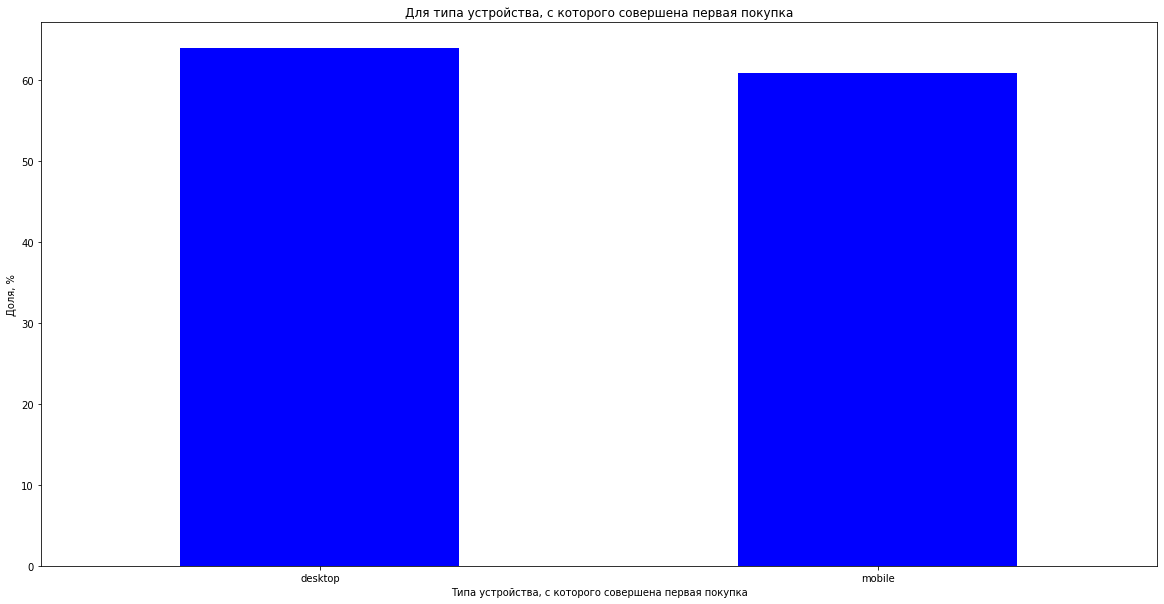

In [59]:
first_device_type = first_device_type.sort_values('two_or_more', ascending=False).reset_index(drop=True)
first_device_type.plot(
    kind='bar',
    title = 'Для типа устройства, с которого совершена первая покупка',
    legend = False,
    x = 'type_device', y='two_or_more',
    color = 'blue',
    xlabel = 'Типа устройства, с которого совершена первая покупка',
    ylabel = 'Доля, %',
    rot = 0,
    figsize = (20,10))
plt.show()

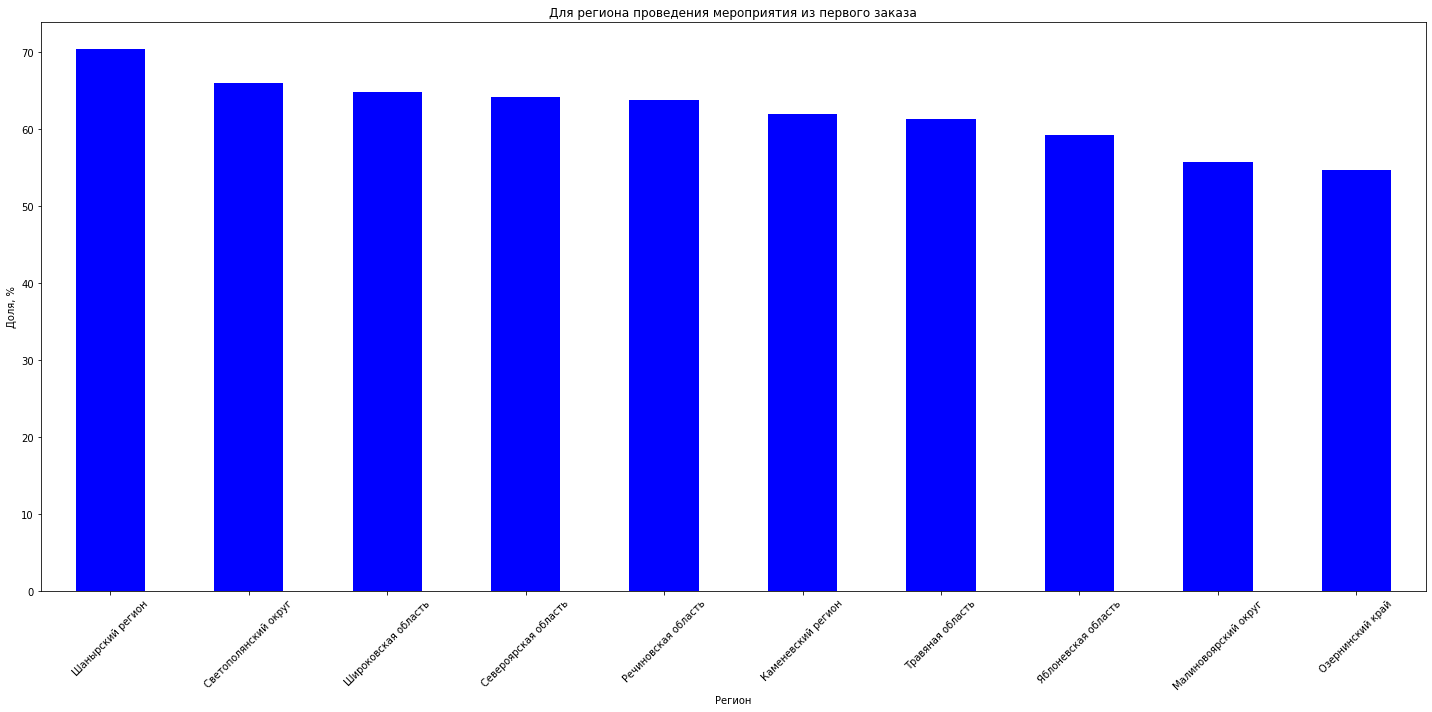

In [60]:
top_10 = (
    first_region_type
    .sort_values('user_count', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_10_sorted = top_10.sort_values('two_or_more', ascending=False).reset_index(drop=True)
top_10_sorted.plot(
    kind='bar',
    title='Для региона проведения мероприятия из первого заказа',
    legend=False,
    x='region',
    y='two_or_more',
    color='blue',
    xlabel='Регион',
    ylabel='Доля, %',
    rot=45,
    figsize=(20, 10)
)
plt.tight_layout()
plt.show()

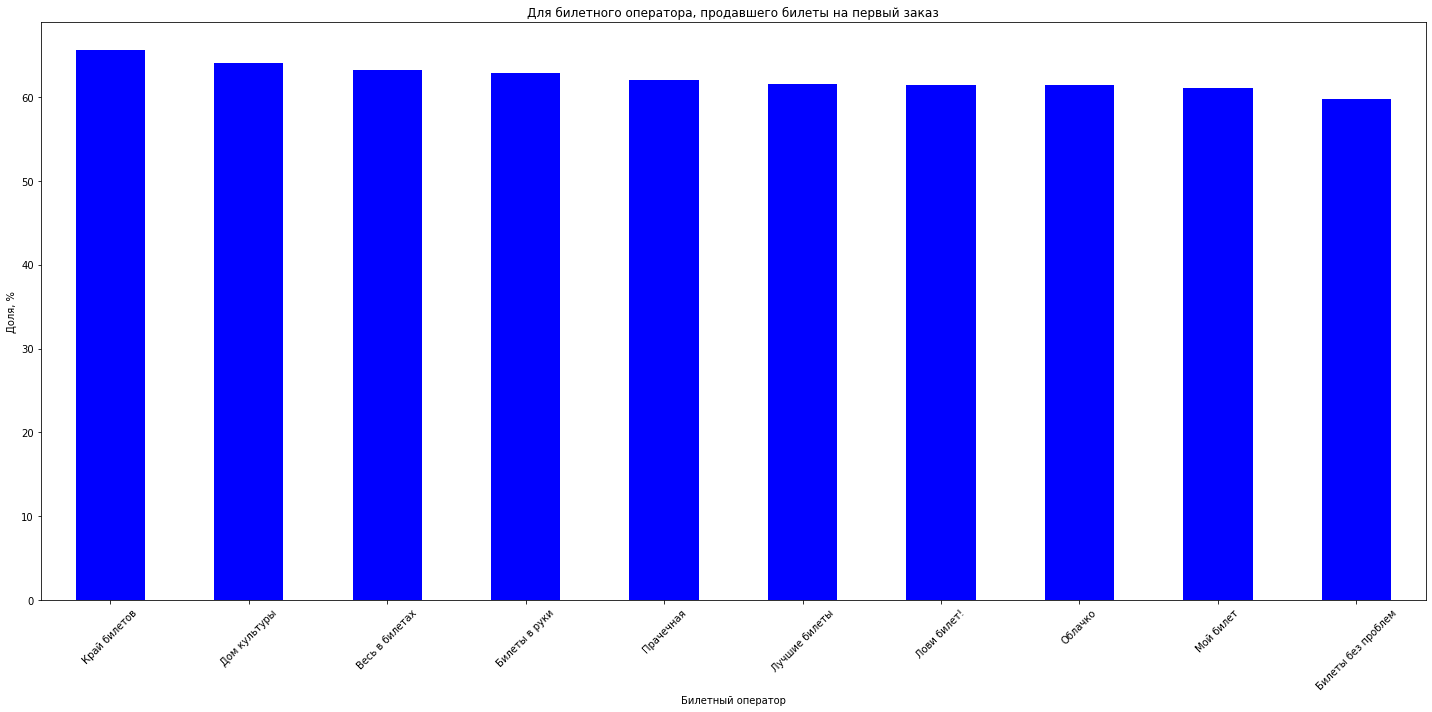

In [61]:
top_10 = (
    first_service_type
    .sort_values('user_count', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_10_sorted = top_10.sort_values('two_or_more', ascending=False).reset_index(drop=True)
top_10_sorted.plot(
    kind='bar',
    title='Для билетного оператора, продавшего билеты на первый заказ',
    legend=False,
    x='ticket_partner',
    y='two_or_more',
    color='blue',
    xlabel='Билетный оператор',
    ylabel='Доля, %',
    rot=45,
    figsize=(20, 10)
)
plt.tight_layout()
plt.show()

## Промежуточные выводы:
* Для всех типов всех сортировок характерны значения от 60 до 70%

## Задача 4.1.3. Проверка гипотез:

### Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

Для спортивных мероприятий вероятность повторного заказа составляет 55%, для концертов - 62%. Гипотеза не подтверджается

### Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Топ 3 региона по количеству пользователей:
* 0	Каменевский регион	7013	61.999144
* 1	Североярская область	3782	64.225278
* 2	Широковская область	1246	64.847512

Последние 3 региона по количеству пользователей:
* 7	Травяная область	458		61.353712
* 8	Речиновская область	440		63.863636
* 9	Яблоневская область	412		59.223301

Как можно видеть - процентоное соотношение близко, однако для более активных регионов доля повторных заказов чуть выше. Гипотезу можно подтвердить, но разницу можно считать незначительной

# 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

## Задача 4.2.1. Cвязь между средней выручкой сервиса с заказа и повторными заказами.

Пользователи с одним заказом:

In [62]:
group_a = profile[profile['is_two'] == 0]['avg_revenue_rub']

Пользователи с двумя и более:

In [63]:
group_b = profile[profile['is_two'] == 1]['avg_revenue_rub']

Гистограмма:

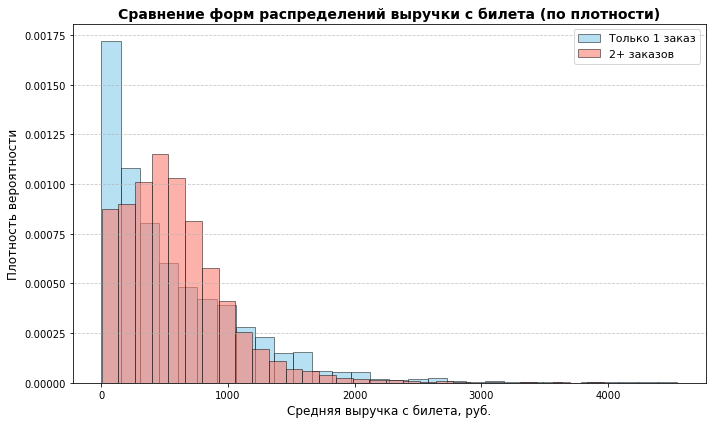

In [64]:
bins = 30

plt.figure(figsize=(10, 6))
plt.hist(
    group_a,
    bins=bins,
    alpha=0.6,
    label='Только 1 заказ',
    color='skyblue',
    edgecolor='black',
    density=True,
    linewidth=0.8
)
plt.hist(
    group_b,
    bins=bins,
    alpha=0.6,
    label='2+ заказов',
    color='salmon',
    edgecolor='black',
    density=True, 
    linewidth=0.8
)

plt.title('Сравнение форм распределений выручки с билета (по плотности)', fontsize=14, fontweight='bold')
plt.xlabel('Средняя выручка с билета, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [65]:
mean_a = group_a.mean()
mean_b = group_b.mean()

print(f"Средняя выручка (1 заказ):       {mean_a:.2f} руб.")
print(f"Средняя выручка (2+ заказов):      {mean_b:.2f} руб.")
print(f"Разница:                        {mean_b - mean_a:.2f} руб.")

Средняя выручка (1 заказ):       566.32 руб.
Средняя выручка (2+ заказов):      575.23 руб.
Разница:                        8.91 руб.


## Промежуточные выводы:
* Диапазон средней выручки для совершивших только 1 заказ пользователей и 2+ в целом идентичен - в районе 570 рублей.
* Различия между группами присутствует - если для совершивших 1 заказ пользователей характерна покупка дешевых билетов с пиком в минимальное значение стоимости билета, то для 2+ и более пользователей пик смещен в правую сторону - сторону увеличение цены. В целом можно отметить, что вернувшиеся пользователи платят за билеты больше

## Задача 4.2.2. Распределение по средней выручке с заказа в двух группах пользователей

Пользователи с заказами от 2 до 4:

In [66]:
group_c = profile[profile['is_two'] == 1 & (profile['is_five'] == 0)]['avg_revenue_rub']

Пользователи с заказами от 5 и более:

In [67]:
group_d = profile[profile['is_five'] == 1]['avg_revenue_rub']

Гистограмма:

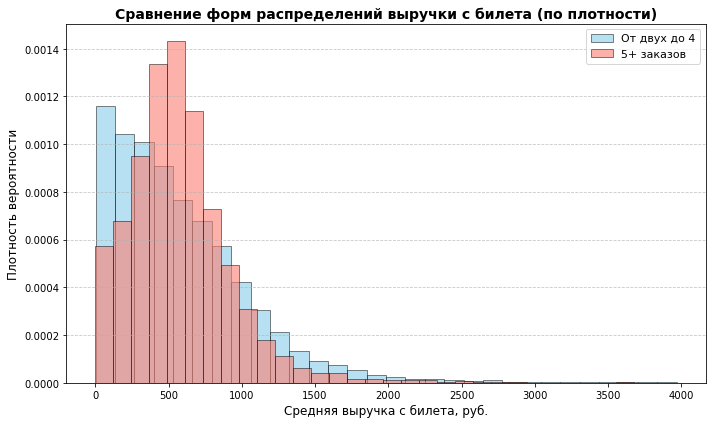

In [68]:
bins = 30

plt.figure(figsize=(10, 6))
plt.hist(
    group_c,
    bins=bins,
    alpha=0.6,
    label='От двух до 4',
    color='skyblue',
    edgecolor='black',
    density=True,
    linewidth=0.8
)
plt.hist(
    group_d,
    bins=bins,
    alpha=0.6,
    label='5+ заказов',
    color='salmon',
    edgecolor='black',
    density=True, 
    linewidth=0.8
)

plt.title('Сравнение форм распределений выручки с билета (по плотности)', fontsize=14, fontweight='bold')
plt.xlabel('Средняя выручка с билета, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
mean_c = group_c.mean()
mean_d = group_d.mean()

print(f"Средняя выручка (1 заказ):       {mean_c:.2f} руб.")
print(f"Средняя выручка (2+ заказов):      {mean_d:.2f} руб.")
print(f"Разница:                        {mean_d - mean_c:.2f} руб.")

Средняя выручка (1 заказ):       577.61 руб.
Средняя выручка (2+ заказов):      572.46 руб.
Разница:                        -5.15 руб.


## Промежуточные выводы:
* Диапазон средней выручки для совершивших от 2 до 4 заказов пользователей и 5+ в целом идентичен - в районе 575 рублей (чуть более разницы между предыдущими группами)
* Различия между группами присутствует - в зависимости от количества заказов пик среднего числа цены смещается правее в большую сторону - чем больше заказов совершает пользователь, тем дороже его билет.

## Задача 4.2.3. Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки

Распределение пользователей по среднему количеству билетов в заказе:

In [70]:
print("Статистика по avg_tickets_count:")
print(profile['avg_tickets'].describe())

Статистика по avg_tickets_count:
count    21553.000000
mean         2.757742
std          0.924289
min          1.000000
25%          2.000000
50%          2.777778
75%          3.148148
max         11.000000
Name: avg_tickets, dtype: float64


### Промежуточные выводы:
* Около 75% пользователей покупает не более 3 билетов;
* среднее и медианное значения близки, что говорит о симметричности распределения;
* присутвуют выбросы в части больших значений билетов;

Разделение пользователей на несколько сегментов по среднему количеству билетов в заказе и доля пользователей с повторными заказами:

In [71]:
profile['avg_tickets'] = pd.cut(profile['avg_tickets'], bins=[1, 2, 3, 5, 100], labels=['1-2', '2-3', '3-5', '5+'], right=False)

In [72]:
tickets_bins = profile.groupby('avg_tickets', observed=False).agg(
    user_count=('user_id', 'count'),
    two_or_more=('is_two', 'mean')
).reset_index() 
tickets_bins['two_or_more'] = tickets_bins['two_or_more'] * 100

tickets_bins = tickets_bins.sort_values('avg_tickets').reset_index(drop=True)
tickets_bins.head(10)


,avg_tickets,user_count,two_or_more
0,1-2,2374,51.053075
1,2-3,9354,73.433825
2,3-5,9141,54.917405
3,5+,684,19.444444


## Выводы:
* Пользователи по сегментам распределены не равномерно - основная доля распределена между группами "2-3" и "3-5" билетов в равной степени;
* Сегменты с аномально низкой долей повторных покупок - 5 и более заказов;
* Сегменты с аномально высокой долей повторных покупок - 2-3 заказов.

# 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

## Задача 4.3.1. Анализ того, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

День недели первой покупки

In [73]:
profile['first_order_dayofweek'] = profile['first_order_date'].dt.dayofweek

In [74]:
dayofweek_bins = profile.groupby('first_order_dayofweek', observed=False).agg(
    user_count=('user_id', 'count'),
    two_or_more=('is_two', 'mean')
).reset_index()     

dayofweek_bins['two_or_more'] = dayofweek_bins['two_or_more'] * 100

dayofweek_bins['first_order_dayofweek'] = dayofweek_bins['first_order_dayofweek'].map({
    0: 'Понедельник',   
    1: 'Вторник',
    2: 'Среда',     
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
})
dayofweek_bins.head(10)

,first_order_dayofweek,user_count,two_or_more
0,Понедельник,2906,62.801101
1,Вторник,3187,62.158770
2,Среда,3061,62.267233
3,Четверг,3104,59.568299
4,Пятница,3239,60.018524
5,Суббота,3292,62.667072
6,Воскресенье,2764,60.274964


### Вывод:
* День недели, в которую совершена первая покупка, на вероятность возврата клиента фактически не влияет

## Задача 4.3.2. Изучение, как средний интервал между заказами влияет на удержание клиентов

Cреднее время между заказами для пользователей, совершивших 2–4 заказа

In [75]:
average_days_2_or_more = profile[
    (profile['is_two'] == 1) & 
    (profile['is_five'] == 0)
]['days_between_orders'].mean()

Cреднее время между заказами для пользователей, совершившие 5 и более заказов

In [76]:
average_days_5_or_more = profile[profile['is_five'] == 1]['days_between_orders'].mean()

In [77]:
print(f"Среднее время между заказами для пользователей с 2-4 заказа: {average_days_2_or_more:.2f} дней")
print(f"Среднее время между заказами для пользователей с 5 и более заказами: {average_days_5_or_more:.2f} дней")

Среднее время между заказами для пользователей с 2-4 заказа: 21.33 дней
Среднее время между заказами для пользователей с 5 и более заказами: 10.01 дней


### Вывод:
Средний интервал между заказами не влияет на вероятность повторного заказа - для пользователей с 2-4 заказами интервал равен более 21 дня, однако вероятность повторного заказа из расчетов выше составляет около 60%, а для пользователей с 5+ заказами, где интервал равен 10 дней - вероятность равна 20%.

# 4.4. Корреляционный анализ количества покупок и признаков пользователя

# Задача 4.4.1: Проведение корреляционного анализа

Рассчет коэффициента корреляции phi_k между признаками профиля пользователя и числом заказов (total_orders). Перед этим вывод ифнормации, какие столбцы можно использовать для расчета корреляции

In [78]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21553 entries, 0 to 21770
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21553 non-null  object        
 1   first_order_date       21553 non-null  datetime64[ns]
 2   last_order_date        21553 non-null  datetime64[ns]
 3   type_device            21553 non-null  object        
 4   region                 21553 non-null  object        
 5   ticket_partner         21553 non-null  object        
 6   first_event_type       21553 non-null  object        
 7   total_orders           21553 non-null  int64         
 8   avg_revenue_rub        21553 non-null  float64       
 9   avg_tickets            21553 non-null  category      
 10  days_between_orders    13234 non-null  float64       
 11  is_two                 21553 non-null  uint8         
 12  is_five                21553 non-null  uint8         
 13  f

In [79]:
profile_phik = profile[[
    'type_device',
    'region',
    'ticket_partner',                
    'first_event_type',
    'total_orders',
    'is_two',
    'is_five'
]]      
# Рассчитаем матрицу корреляций phik
phik_matrix = profile_phik.phik_matrix(interval_cols=[
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets',
    'days_between_orders'
])
# Выведем матрицу
phik_matrix.style.background_gradient(cmap='coolwarm').format("{:.2f}")

,type_device,region,ticket_partner,first_event_type,total_orders,is_two,is_five
type_device,1.00,0.11,0.09,0.07,0.01,0.04,0.05
region,0.11,1.00,0.70,0.51,0.12,0.08,0.09
ticket_partner,0.09,0.70,1.00,0.59,0.03,0.05,0.06
first_event_type,0.07,0.51,0.59,1.00,0.02,0.03,0.03
total_orders,0.01,0.12,0.03,0.02,1.00,0.32,0.63
is_two,0.04,0.08,0.05,0.03,0.32,1.00,0.71
is_five,0.05,0.09,0.06,0.03,0.63,0.71,1.00


# Вывод: 
* Из выбранных столбцов практически никакие не связаны с количеством заказов. Можно лишь отметить слабую связь с регионом - 0,12

# 5. Общие выводы и рекомендации

В результате проектной работы было выяснено следующее:
* Всего 290611 строк и 15 столбцов;
* Все цены были переведены в рубли с учетом курса (например, с валюты тенге)
* Был создан профиль пользователей с ключевыми данными, в который были добавлены столбцы с количеством заказов 2+ и 5+
* Добавлены бинарные признаки: made_2_or_more_orders и made_5_or_more_orders для пользователей с ≥2 и ≥5 заказами.

Основными результатами анализа являются следующие значения:
* Общее число пользователей: 21771
* Средняя выручка с одного заказа: 571.58 руб.
* Доля пользователей с 2 и более заказами: 61.79%
* Доля пользователей с 5 и более заказами: 29.04%


Для типов первого мероприятия можно сказать, что 45% посетителей впервые пришло на концерты, далее пришлось на тип "другое" 24% и третьим по счету по популярности являются театры - 20%.
Основная часть пользователей заказ осуществляет с мобильного устройства - 83%;
Каменевский район и Североярская область активнее проводили первые мероприятия - 32,5 и 17,5%. Остальные районы - 5 и менее процентов;
Выделяется один крупный билетный оператор - билеты без проблем, на чью долю приходится 23%. Далее в среднем по 12% на каждый составляет группа из 4 операторов. Остальные - 6 и менее процентов


Диапазон средней выручки для совершивших 1, от 2 до 4 заказов пользователей и 5+ в целом идентичен - в районе 570 рублей. Присутствуют различия между группами, так как в зависимости от количества заказов пик среднего числа цены смещается правее в большую сторону - чем больше заказов совершает пользователь, тем дороже его билет.

Корреляция между количеством заказов типом девайса, билетным партнером и первым типом мероприятия отсуствует. Слабая корреляция присутсувует между количеством заказов и регионом

Рекомендации заказчику:
* Уделить внимания мобильным приложениям - интерфейсу, удобству, доступности - большинство заказов совершаются именно там
* Уделить внимание таким типам мероприятий как концерты и театры из-за их популярности - например, предусмотреть отсутствие постановок с низкими рейтингами; а для низко популярных типов (выставки, спорт) - к примеру, же ввести какие-то бонусы при посещении
* Предложить также можно скидки для пользователей с большим количеством билетов - около 75% людей совершают не более 3 заказов
* Скидки или что-то схожее также можно предложить для активных клиентов, чей интервал между заказами составляет около 10 дней.


# 6. Финализация проекта и публикация в Git